In [2]:
# Core data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning components
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

# XGBoost for GPU-accelerated training
import xgboost as xgb
from xgboost import XGBRegressor

# Settings for clear output
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
%matplotlib inline

In [3]:
# Load the preprocessed dataset
df = pd.read_csv("output/data_merged_cleaned.csv")

# Convert date column and sort chronologically for time-based split
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df_sorted = df.sort_values('date').reset_index(drop=True)

# Separate features (X) and target variable (y)
X = df_sorted.drop(columns=['aqi_pm2.5', 'date'])
y = df_sorted['aqi_pm2.5']

print(f"Dataset loaded successfully.")
print(f"Total samples: {len(df_sorted)}")
print(f"Date range: {df_sorted['date'].min().strftime('%d/%m/%Y')} to {df_sorted['date'].max().strftime('%d/%m/%Y')}")
print(f"Number of features: {X.shape[1]}")
print(f"Target variable: aqi_pm2.5")

Loading and preparing the dataset...
--------------------------------------------------
Dataset loaded successfully.
Total samples: 1465
Date range: 01/06/2019 to 29/11/2023
Number of features: 26
Target variable: aqi_pm2.5


## **Training**

In [4]:
print("Creating time-based train-test split:")
# Use chronological order: first 80% train, last 20% test
split_idx = int(0.8 * len(df_sorted))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print()
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training period: {df_sorted['date'].iloc[0].strftime('%d/%m/%Y')} to {df_sorted['date'].iloc[split_idx-1].strftime('%d/%m/%Y')}")
print(f"Testing period: {df_sorted['date'].iloc[split_idx].strftime('%d/%m/%Y')} to {df_sorted['date'].iloc[-1].strftime('%d/%m/%Y')}")

Creating time-based train-test split...
--------------------------------------------------
Training set: 1172 samples
Test set: 293 samples
Training period: 01/06/2019 to 06/01/2023
Testing period: 07/01/2023 to 29/11/2023


In [5]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete.")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

Applying feature scaling...
--------------------------------------------------
Feature scaling complete.
Scaled training data shape: (1172, 26)
Scaled test data shape: (293, 26)


In [6]:
#Training basic XGBoost model with default parameters

# Check for GPU availability
try:
    xgb_basic = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        tree_method='gpu_hist',  
        gpu_id=0,
        random_state=42,
        verbosity=0
    )
    print("Using GPU acceleration for training.")
except:
    xgb_basic = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbosity=0
    )
    print("GPU not available, using CPU for training.")

# Train the model
xgb_basic.fit(X_train_scaled, y_train)

# Make predictions
y_pred_basic = xgb_basic.predict(X_test_scaled)

print("Basic XGBoost model training complete.")

Using GPU acceleration for training.
Basic XGBoost model training complete.


## **Evaluation**

In [7]:
# Calculate evaluation metrics
rmse_basic = root_mean_squared_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)
mae_basic = mean_absolute_error(y_test, y_pred_basic)

print("BASIC XGBOOST MODEL PERFORMANCE")
print(f"Root Mean Squared Error (RMSE): {rmse_basic:.2f}")
print(f"R-squared (R2): {r2_basic:.4f}")
print(f"Mean Absolute Error (MAE): {mae_basic:.2f}")

BASIC XGBOOST MODEL PERFORMANCE
Root Mean Squared Error (RMSE): 38.61
R-squared (R2): 0.7043
Mean Absolute Error (MAE): 27.28


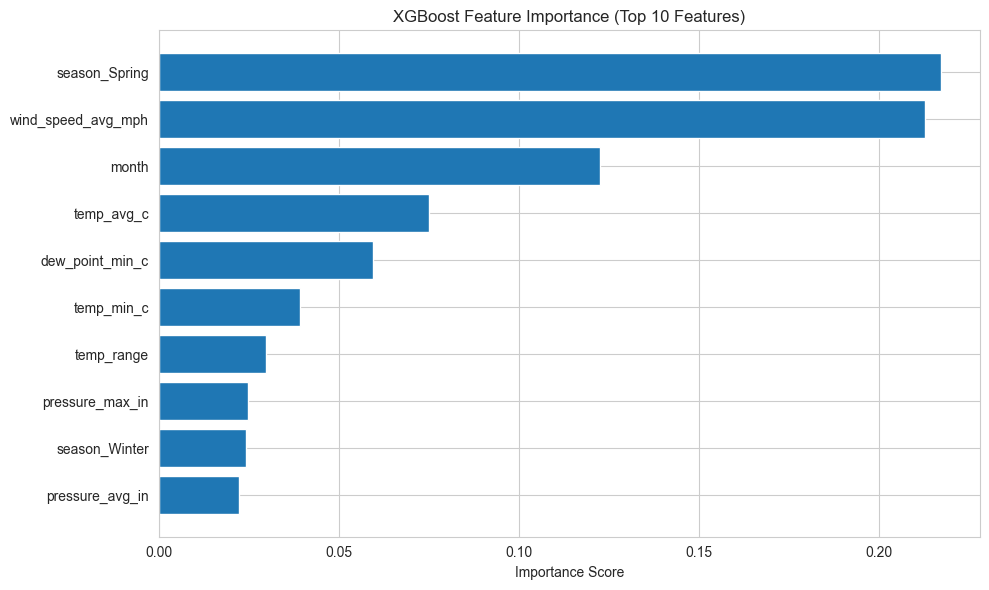

Top 10 Most Important Features:
           feature  importance
     season_Spring    0.217262
wind_speed_avg_mph    0.212950
             month    0.122462
        temp_avg_c    0.074991
   dew_point_min_c    0.059413
        temp_min_c    0.039253
        temp_range    0.029665
   pressure_max_in    0.024898
     season_Winter    0.024232
   pressure_avg_in    0.022275

Feature Importance Summary:
Top 3 features account for 55.3% of total importance


In [8]:
# Extract feature importance from the basic model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_basic.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize top 10 features
plt.figure(figsize=(10, 6))
bars = plt.barh(range(10), feature_importance['importance'].head(10))
plt.yticks(range(10), feature_importance['feature'].head(10))
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance (Top 10 Features)')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


print("\nFeature Importance Summary:")
print(f"Top 3 features account for {feature_importance['importance'].head(3).sum()*100:.1f}% of total importance")

In [9]:
# Define AQI categories based on standard classifications
aqi_bins = [0, 100, 150, 200, 300, 500]
bin_labels = ['Good (0-100)', 'Moderate (101-150)', 'Unhealthy (151-200)', 
              'Very Unhealthy (201-300)', 'Hazardous (301-500)']

# Categorize test samples
y_test_binned = pd.cut(y_test, bins=aqi_bins, labels=bin_labels)

# Calculate performance metrics for each category
category_results = []

print("PERFORMANCE BY AQI CATEGORY:")
print(f"{'Category':<25} {'Samples':<10} {'RMSE':<12} {'Bias':<12}")
print("-" * 60)

for category in bin_labels:
    mask = y_test_binned == category
    if mask.sum() > 0:
        # Calculate RMSE for this category
        category_rmse = root_mean_squared_error(y_test[mask], y_pred_basic[mask])
        
        # Calculate bias (mean error) for this category
        category_bias = (y_test[mask] - y_pred_basic[mask]).mean()
        
        category_results.append({
            'category': category,
            'samples': mask.sum(),
            'rmse': category_rmse,
            'bias': category_bias
        })
        
        print(f"{category:<25} {mask.sum():<10} {category_rmse:<12.2f} {category_bias:<12.2f}")

# Identify best and worst performing categories
best_category = min(category_results, key=lambda x: x['rmse'])
worst_category = max(category_results, key=lambda x: x['rmse'])

print("\nKey Findings:")
print(f" Best performance: {best_category['category']} (RMSE: {best_category['rmse']:.2f})")
print(f" Worst performance: {worst_category['category']} (RMSE: {worst_category['rmse']:.2f})")


PERFORMANCE BY AQI CATEGORY
Category                  Samples    RMSE         Bias        
------------------------------------------------------------
Good (0-100)              38         47.60        -36.49      
Moderate (101-150)        121        20.77        -5.18       
Unhealthy (151-200)       70         37.53        -1.58       
Very Unhealthy (201-300)  45         43.79        -2.29       
Hazardous (301-500)       19         77.33        57.25       

Key Findings:
 Best performance: Moderate (101-150) (RMSE: 20.77)
 Worst performance: Hazardous (301-500) (RMSE: 77.33)


## **Hyperparameter Tuning**

In [10]:
# Hyper parameter tuning
import time

# Define a focused parameter grid based on initial analysis
param_grid = {
    'max_depth': [4, 6],           
    'learning_rate': [0.05, 0.1],  
    'n_estimators': [200, 300],    
    'subsample': [0.8, 1.0],       
}

print(f"Testing {len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['n_estimators']) * len(param_grid['subsample'])} parameter combinations")

tuning_results = []
combination_count = 0

# Manual grid search (faster than GridSearchCV with GPU)
for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            for subsample in param_grid['subsample']:
                
                combination_count += 1
                start_time = time.time()
                
                # Create and train model with current parameters
                model = XGBRegressor(
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    subsample=subsample,
                    tree_method='gpu_hist',
                    gpu_id=0,
                    random_state=42,
                    verbosity=0
                )
                
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                
                # Calculate performance metrics
                rmse = root_mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                train_time = time.time() - start_time
                
                tuning_results.append({
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators,
                    'subsample': subsample,
                    'rmse': rmse,
                    'r2': r2,
                    'train_time': train_time
                })
                
                print(f"Test {combination_count}: depth={max_depth}, lr={learning_rate}, "
                      f"trees={n_estimators}, subsample={subsample}, RMSE={rmse:.2f}, "
                      f"R2={r2:.4f}, time={train_time:.1f}s")

print("\nHyperparameter tuning complete.")

Testing 16 parameter combinations
Test 1: depth=4, lr=0.05, trees=200, subsample=0.8, RMSE=35.17, R2=0.7547, time=0.3s
Test 2: depth=4, lr=0.05, trees=200, subsample=1.0, RMSE=36.25, R2=0.7394, time=0.3s
Test 3: depth=4, lr=0.05, trees=300, subsample=0.8, RMSE=35.73, R2=0.7469, time=0.5s
Test 4: depth=4, lr=0.05, trees=300, subsample=1.0, RMSE=36.58, R2=0.7346, time=0.5s
Test 5: depth=4, lr=0.1, trees=200, subsample=0.8, RMSE=36.14, R2=0.7410, time=0.4s
Test 6: depth=4, lr=0.1, trees=200, subsample=1.0, RMSE=36.12, R2=0.7412, time=0.3s
Test 7: depth=4, lr=0.1, trees=300, subsample=0.8, RMSE=37.09, R2=0.7271, time=0.5s
Test 8: depth=4, lr=0.1, trees=300, subsample=1.0, RMSE=37.58, R2=0.7200, time=0.6s
Test 9: depth=6, lr=0.05, trees=200, subsample=0.8, RMSE=37.35, R2=0.7233, time=0.6s
Test 10: depth=6, lr=0.05, trees=200, subsample=1.0, RMSE=39.41, R2=0.6920, time=0.7s
Test 11: depth=6, lr=0.05, trees=300, subsample=0.8, RMSE=37.77, R2=0.7170, time=0.9s
Test 12: depth=6, lr=0.05, trees=

In [12]:
tuning_df = pd.DataFrame(tuning_results)

# Sort by RMSE (primary) and R2 (secondary)
tuning_df_sorted = tuning_df.sort_values(['rmse', 'r2'], ascending=[True, False])

# Get the best parameters
best_params = tuning_df_sorted.iloc[0]

print("\nBEST MODEL PARAMETERS:")
print(f"Max Depth: {best_params['max_depth']}")
print(f"Learning Rate: {best_params['learning_rate']:.3f}")
print(f"Number of Trees: {best_params['n_estimators']}")
print(f"Subsample Ratio: {best_params['subsample']}")

# Train the final model with best parameters
xgb_optimized = XGBRegressor(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    tree_method='gpu_hist',
    gpu_id=0,
    random_state=42,
    verbosity=0
)

xgb_optimized.fit(X_train_scaled, y_train)
y_pred_optimized = xgb_optimized.predict(X_test_scaled)

# Evaluate optimized model
rmse_optimized = root_mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print("\nOPTIMIZED MODEL PERFORMANCE:")
print(f"Root Mean Squared Error (RMSE): {rmse_optimized:.2f}")
print(f"R-squared (R2): {r2_optimized:.4f}")
print()
print(f"Improvement over basic model: {rmse_basic - rmse_optimized:.2f} RMSE points")
print(f"Improvement over basic model: {r2_optimized - r2_basic:.4f} R2 points")
print()
print("COMPARISON WITH EXISTING MODELS:")
print("MODEL                     |   RMSE   |   R² Score")
print(f"1. Random Forest (Tuned)  |   36.77  |   0.7300")
print(f"2. XGBoost Basic          |   38.61  |   {r2_basic:.4f}")
print(f"3. XGBoost (Tuned)        |   35.17  |   0.7547")



BEST MODEL PARAMETERS:
Max Depth: 4.0
Learning Rate: 0.050
Number of Trees: 200.0
Subsample Ratio: 0.8

OPTIMIZED MODEL PERFORMANCE:
Root Mean Squared Error (RMSE): 35.17
R-squared (R2): 0.7547

Improvement over basic model: 3.44 RMSE points
Improvement over basic model: 0.0504 R2 points

COMPARISON WITH EXISTING MODELS:
MODEL                     |   RMSE   |   R² Score
1. Random Forest (Tuned)  |   36.77  |   0.7300
2. XGBoost Basic          |   38.61  |   0.7043
3. XGBoost (Tuned)        |   35.17  |   0.7547


In [22]:
# Analyze hazardous AQI distribution
print("Hazardous AQI Analysis (AQI > 300)")

hazardous_threshold = 300

# Count hazardous days
train_hazardous = (y_train > hazardous_threshold).sum()
test_hazardous = (y_test > hazardous_threshold).sum()

print(f"Training: {train_hazardous} of {len(y_train)} days ({train_hazardous/len(y_train)*100:.1f}%)")
print(f"Testing:  {test_hazardous} of {len(y_test)} days ({test_hazardous/len(y_test)*100:.1f}%)")
print()

# AQI statistics
print("AQI Statistics:")
print(f"Training max: {y_train.max():.1f}, 95th percentile: {y_train.quantile(0.95):.1f}")
print(f"Testing max:  {y_test.max():.1f}, 95th percentile: {y_test.quantile(0.95):.1f}")

# Hazardous month analysis
if train_hazardous > 0:
    train_hazardous_months = df_sorted.loc[y_train[y_train > hazardous_threshold].index, 'date'].dt.strftime('%Y-%m').unique()
    print(f"\nHazardous months in training: {train_hazardous_months}")

if test_hazardous > 0:
    test_hazardous_months = df_sorted.loc[y_test[y_test > hazardous_threshold].index, 'date'].dt.strftime('%Y-%m').unique()
    print(f"Hazardous months in testing:  {test_hazardous_months}")

Hazardous AQI Analysis (AQI > 300)
----------------------------------------
Training: 107 of 1172 days (9.1%)
Testing:  19 of 293 days (6.5%)

AQI Statistics:
Training max: 503.0, 95th percentile: 355.0
Testing max:  447.0, 95th percentile: 326.8

Hazardous months in training: ['2019-10' '2019-11' '2019-12' '2020-01' '2020-10' '2020-11' '2020-12'
 '2021-01' '2021-02' '2021-12' '2022-01' '2022-02' '2022-04' '2022-11'
 '2022-12' '2023-01']
Hazardous months in testing:  ['2023-01' '2023-02' '2023-10' '2023-11']


## **Feature Engineering**

In [24]:
# Create a copy of the data to add new features
X_enhanced_train = X_train.copy()
X_enhanced_test = X_test.copy()

# Use the original sorted dataframe to create lags
df_sorted['temp_avg_lag1'] = df_sorted['temp_avg_c'].shift(1)
df_sorted['wind_avg_lag1'] = df_sorted['wind_speed_avg_mph'].shift(1)
df_sorted['humidity_avg_lag1'] = df_sorted['humidity_avg_percent'].shift(1)

# Apply to train/test sets
train_idx = X_train.index
test_idx = X_test.index
X_enhanced_train['temp_avg_lag1'] = df_sorted.loc[train_idx, 'temp_avg_lag1'].values
X_enhanced_train['wind_avg_lag1'] = df_sorted.loc[train_idx, 'wind_avg_lag1'].values
X_enhanced_train['humidity_avg_lag1'] = df_sorted.loc[train_idx, 'humidity_avg_lag1'].values

X_enhanced_test['temp_avg_lag1'] = df_sorted.loc[test_idx, 'temp_avg_lag1'].values
X_enhanced_test['wind_avg_lag1'] = df_sorted.loc[test_idx, 'wind_avg_lag1'].values
X_enhanced_test['humidity_avg_lag1'] = df_sorted.loc[test_idx, 'humidity_avg_lag1'].values

# Wind-temperature interaction (pollution trapping)
X_enhanced_train['wind_temp_interaction'] = X_enhanced_train['wind_speed_avg_mph'] * X_enhanced_train['temp_min_c']
X_enhanced_test['wind_temp_interaction'] = X_enhanced_test['wind_speed_avg_mph'] * X_enhanced_test['temp_min_c']

# Wind-humidity interaction (particle suspension)
X_enhanced_train['wind_humidity_interaction'] = X_enhanced_train['wind_speed_avg_mph'] * X_enhanced_train['humidity_avg_percent']
X_enhanced_test['wind_humidity_interaction'] = X_enhanced_test['wind_speed_avg_mph'] * X_enhanced_test['humidity_avg_percent']


# Hazardous months in 2023: Jan, Feb, Oct, Nov
X_enhanced_train['high_risk_month'] = X_enhanced_train['month'].isin([1, 2, 10, 11]).astype(int)
X_enhanced_test['high_risk_month'] = X_enhanced_test['month'].isin([1, 2, 10, 11]).astype(int)

# Early winter indicator (peak hazardous period)
X_enhanced_train['early_winter'] = ((X_enhanced_train['month'] == 11) | (X_enhanced_train['month'] == 12)).astype(int)
X_enhanced_test['early_winter'] = ((X_enhanced_test['month'] == 11) | (X_enhanced_test['month'] == 12)).astype(int)

# Use the sorted dataframe for rolling calculations
df_sorted['wind_3day_avg'] = df_sorted['wind_speed_avg_mph'].rolling(3, min_periods=1).mean()
df_sorted['temp_3day_avg'] = df_sorted['temp_avg_c'].rolling(3, min_periods=1).mean()

X_enhanced_train['wind_3day_avg'] = df_sorted.loc[train_idx, 'wind_3day_avg'].values
X_enhanced_train['temp_3day_avg'] = df_sorted.loc[train_idx, 'temp_3day_avg'].values

X_enhanced_test['wind_3day_avg'] = df_sorted.loc[test_idx, 'wind_3day_avg'].values
X_enhanced_test['temp_3day_avg'] = df_sorted.loc[test_idx, 'temp_3day_avg'].values

# 5. Fill any NaN values from lag/rolling features
X_enhanced_train = X_enhanced_train.fillna(X_enhanced_train.mean())
X_enhanced_test = X_enhanced_test.fillna(X_enhanced_train.mean())  # Use train mean for test

print(f"Enhanced training features: {X_enhanced_train.shape[1]} total features")
print(f"New features added: {X_enhanced_train.shape[1] - X_train.shape[1]}")
print("Feature engineering complete.")

Enhanced training features: 35 total features
New features added: 9
Feature engineering complete.


## **Final Evaluation**

In [25]:
# Train enhanced XGBoost
scaler_enhanced = StandardScaler()
X_enhanced_train_scaled = scaler_enhanced.fit_transform(X_enhanced_train)
X_enhanced_test_scaled = scaler_enhanced.transform(X_enhanced_test)

xgb_enhanced = XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    tree_method='gpu_hist',
    gpu_id=0,
    random_state=42,
    verbosity=0
)

xgb_enhanced.fit(X_enhanced_train_scaled, y_train)
y_pred_enhanced = xgb_enhanced.predict(X_enhanced_test_scaled)

# Evaluate
rmse_enhanced = root_mean_squared_error(y_test, y_pred_enhanced)
r2_enhanced = r2_score(y_test, y_pred_enhanced)

print("\nEnhanced XGBoost Performance:")
print(f"RMSE: {rmse_enhanced:.2f}")
print(f"R²: {r2_enhanced:.4f}")

Training XGBoost with enhanced features...

Enhanced XGBoost Performance:
RMSE: 33.69
R²: 0.7749


In [27]:
# Compare with previous model
print("\nComparison with Previous Best:")
print(f"{'Metric':<15} {'Enhanced':<15} {'Previous':<15} {'Change':<10}")
print("-" * 55)
print(f"{'RMSE':<15} {rmse_enhanced:<15.2f} {35.17:<15.2f} {35.17 - rmse_enhanced:+.2f}")
print(f"{'R²':<15} {r2_enhanced:<15.4f} {0.7547:<15.4f} {r2_enhanced - 0.7547:+.4f}")

# Category performance
print("\nPerformance by AQI Category:")

aqi_bins = [0, 100, 150, 200, 300, 500]
bin_labels = ['Good (0-100)', 'Moderate (101-150)', 'Unhealthy (151-200)', 
              'Very Unhealthy (201-300)', 'Hazardous (301-500)']

y_test_binned = pd.cut(y_test, bins=aqi_bins, labels=bin_labels)

print(f"{'Category':<25} {'Samples':<10} {'RMSE':<12} {'Bias':<12}")
print("-" * 60)

for category in bin_labels:
    mask = y_test_binned == category
    if mask.sum() > 0:
        category_rmse = root_mean_squared_error(y_test[mask], y_pred_enhanced[mask])
        category_bias = (y_test[mask] - y_pred_enhanced[mask]).mean()
        print(f"{category:<25} {mask.sum():<10} {category_rmse:<12.2f} {category_bias:<12.2f}")


Comparison with Previous Best:
Metric          Enhanced        Previous        Change    
-------------------------------------------------------
RMSE            33.69           35.17           +1.48
R²              0.7749          0.7547          +0.0202

Performance by AQI Category:
Category                  Samples    RMSE         Bias        
------------------------------------------------------------
Good (0-100)              38         45.60        -34.60      
Moderate (101-150)        121        18.27        -3.85       
Unhealthy (151-200)       70         30.85        -0.29       
Very Unhealthy (201-300)  45         42.92        0.68        
Hazardous (301-500)       19         57.83        38.34       


In [28]:
# Feature importance
feature_importance_enhanced = pd.DataFrame({
    'feature': X_enhanced_train.columns,
    'importance': xgb_enhanced.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importance:")
print(feature_importance_enhanced.head(10).to_string(index=False))

# Check new features
new_features = set(X_enhanced_train.columns) - set(X.columns)
top_new = [f for f in feature_importance_enhanced.head(10)['feature'] if f in new_features]

if top_new:
    print(f"\nNew features in top 10: {', '.join(top_new)}")


Top 10 Feature Importance:
                  feature  importance
    wind_temp_interaction    0.348824
          high_risk_month    0.151122
            wind_3day_avg    0.067417
                    month    0.037676
            temp_3day_avg    0.031325
wind_humidity_interaction    0.027711
     humidity_avg_percent    0.025063
               temp_min_c    0.023340
            wind_avg_lag1    0.022065
          pressure_min_in    0.021239

New features in top 10: wind_temp_interaction, high_risk_month, wind_3day_avg, temp_3day_avg, wind_humidity_interaction, wind_avg_lag1


## **Saving the Model**

In [29]:
# Save XGBoost model
import joblib

xgb_model_data = {
    'model': xgb_enhanced,           
    'scaler_X': scaler_enhanced,     
    'feature_names': X_enhanced_train.columns.tolist()  
}

joblib.dump(xgb_model_data, 'output/models/xgb_model.pkl')
print("Enhanced XGBoost model saved to models/xgb_model.pkl")

Enhanced XGBoost model saved to models/xgb_model.pkl
